In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
#switching off scientific notation
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

In [2]:
df = pd.read_csv('Sweden Load Data 2005-2017.csv')
df.rename({'cet_cest_timestamp':'time', 'SE_load_actual_tso':'load'},
          axis='columns', 
          inplace=True)
df['time'] = pd.to_datetime(df['time'],errors='ignore', utc=True)
df['weekday'] = df['time'].dt.weekday

In [3]:
df.head(2)

,time,load,weekday
0,2005-01-01 00:00:00+00:00,15991.34,5
1,2005-01-01 01:00:00+00:00,15673.12,5


In [4]:
# Discharges the batteries. We consume less energy that we would 
# normally do.  
def discharge(agent, timestamp, load):
    discharge_amount = min(load, agent.battery_charge_speed, agent.battery_level)
    agent.battery_level -= discharge_amount
    agent.history.append((timestamp, load - discharge_amount, 'discharge'))

# Charges the batteries. Meaning, the system consumption increases
# by the battery charging speed. 
def charge(agent, timestamp, load):
    charge_amount = min(agent.battery_charge_speed, agent.battery_max - agent.battery_level)
    agent.battery_level += charge_amount
    agent.history.append((timestamp, load + charge_amount, 'charge'))

# Does nothing. The real consumption is the same as original one. 
def wait(agent, timestamp, load):
    agent.history.append((timestamp, load, 'wait'))

ACTION_SPACE = (discharge, charge, wait)

# The policy#1 to compare with. Take the random choice of available ones.
def random_policy(agent, _timestamp, _load):
    return(random.choice(agent.available_actions()))

class Agent2:    
    #class constructor function
    def __init__(self, 
                 battery_level=0,
                 battery_max=400,
                 battery_charge_speed = 100,
                 loads = np.array([]),
                 action_space=ACTION_SPACE, 
                 policy=random_policy,
                 action=wait):
        self.battery_max = battery_max
        self.battery_charge_speed = battery_charge_speed
        self.array_loads = loads
        self.battery_level = battery_level
        self.collection_loads = []
        self.collection_rewards = []
        self.action_space = action_space
        self.action = action
        self.policy = policy
        self.history = []

    # Applies the action chozen at the previous timestamp to the
    # current time and load data. For example, if 1 hour ago we choose to 
    # charge the battery, now we need to increase the default concumption
    # by that value. Then, write it to the alternative history.
    # Afteer saving history, it also chooses action for the next 1 hour. 
    def tick(self, timestamp, load):
        self.action(self, timestamp, load)
        self.action = self.policy(self, timestamp, load)

    # Returns the list of available actions at the current time.abs 
    # For example, if the battery is fully charged, it returns 'wait'
    # and 'discharge', since 'charge' is not allowed. 
    # 'Wait' is always available
    def available_actions(self):
        result = [wait]
        if self.battery_level > 0: result.append(discharge)
        if self.battery_level < self.battery_max: result.append(charge)
        return result

In [5]:
test_df = df.head(50).copy()
agent4 = Agent2(loads = test_df)
for i, row in test_df.iterrows():
    agent4.tick(row['time'], row['load'])
actual_history = pd.DataFrame(agent4.history, columns= ['time', 'load', 'past_action'])

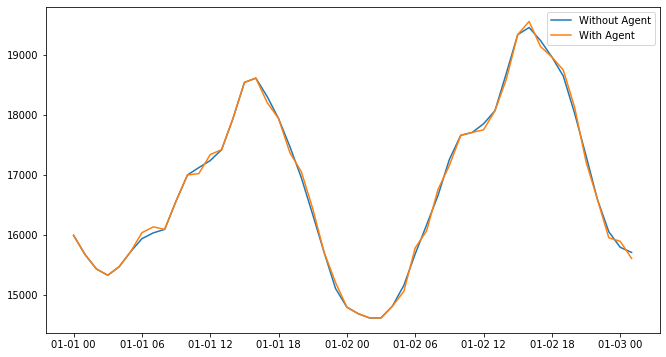

In [28]:
agent4 = Agent2(loads = test_df, 
                 battery_max=400,
                 battery_charge_speed = 100,)
for i, row in test_df.iterrows():
    agent4.tick(row['time'], row['load'])
    
actual_history = pd.DataFrame(agent4.history, columns= ['time', 'load', 'past_action'])

plt.figure(figsize=(11,6))
plt.plot(test_df.time.values,test_df.load.values)
plt.plot(test_df.time.values, actual_history.load)
plt.legend(['Without Agent','With Agent'])
plt.show()

In [14]:
def cost(load):
    return np.sum(5 + 0.5 * load + 0.05 * load ** 2)

print("Total cost without agent:", cost(test_df.load.values))
print("Total cost with random agent:", cost(actual_history.load.values))

Total cost without agent: 709748296.9664352
Total cost with random agent: 709491913.366435


In [6]:
def rule_policy(agent, timestamp, load, min_baseline=15500, max_baseline=18000):
    if load < min_baseline and (charge in agent.available_actions()): return charge 
    if load > max_baseline and (discharge in agent.available_actions()): return discharge
    return wait

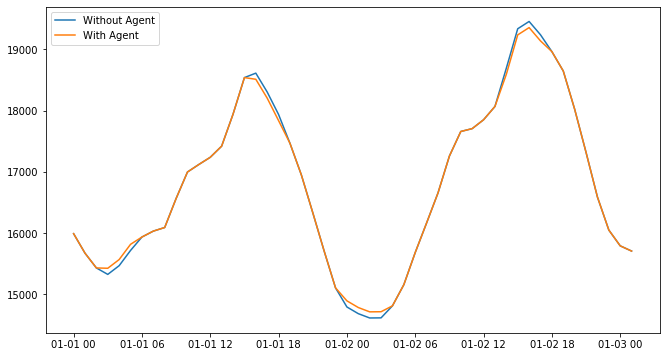

NameError: name 'cost' is not defined

In [7]:
agent5 = Agent2(loads = test_df, 
                 battery_max=400,
                 battery_charge_speed = 100,
                 policy=rule_policy)

for i, row in test_df.iterrows():
    agent5.tick(row['time'], row['load'])
    
actual_history = pd.DataFrame(agent5.history, columns= ['time', 'load', 'past_action'])

plt.figure(figsize=(11,6))
plt.plot(test_df.time.values,test_df.load.values)
plt.plot(test_df.time.values, actual_history.load)
plt.legend(['Without Agent','With Agent'])
plt.show()

print("Total cost without agent:", cost(test_df.load.values))
print("Total cost with random agent:", cost(actual_history.load.values))

In [8]:
def make_dir(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)

Lets take first 80% of data for training

In [10]:
train_size = int(np.around(df.shape[0] * 0.8))
print("Train data size", train_size)
train_data = df[:train_size]
test_data = df[train_size:]
initial_battery_capacity = 400

portfolio_value = []

for e in range(10):
    state = env.reset()

Train data size 91161


NameError: name 'Env' is not defined

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import random

def mlp(n_obs, n_action, n_hidden_layer=1, n_neuron_per_layer=32,
        activation='relu', loss='mse'):
  """ A multi-layer perceptron """
  model = Sequential()
  model.add(Dense(n_neuron_per_layer, input_dim=n_obs, activation=activation))
  for _ in range(n_hidden_layer):
    model.add(Dense(n_neuron_per_layer, activation=activation))
  model.add(Dense(n_action, activation='linear'))
  model.compile(loss=loss, optimizer=Adam(), metrics=['accuracy'])
  print(model.summary())
  return model

class DQNAgent(object):
    """ A simple Deep Q agent """
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = mlp(state_size, action_size)

    # Applies the action chozen at the previous timestamp to the
    # current time and load data. For example, if 1 hour ago we choose to 
    # charge the battery, now we need to increase the default concumption
    # by that value. Then, write it to the alternative history.
    # Afteer saving history, it also chooses action for the next 1 hour. 
    def tick(self, timestamp, load):
        self.action(self, timestamp, load)
        self.action = self.policy(self, timestamp, load)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size=32):
        """ vectorized implementation; 30x speed up compared with for loop """
        minibatch = random.sample(self.memory, batch_size)
        # import pdb; pdb.set_trace()
        states = np.array([tup[0][0] for tup in minibatch])
        actions = np.array([tup[1] for tup in minibatch])
        rewards = np.array([tup[2] for tup in minibatch])
        next_states = np.array([tup[3][0] for tup in minibatch])
        done = np.array([tup[4] for tup in minibatch])
        # import pdb; pdb.set_trace()
        # Q(s', a)
        target = rewards + self.gamma * np.amax(self.model.predict(next_states), axis=1)
        # end state target is reward itself (no lookahead)
        target[done] = rewards[done]

        # Q(s, a)
        target_f = self.model.predict(states)
        # make the agent to approximately map the current state to future discounted reward
        target_f[range(batch_size), actions] = target

        history = self.model.fit(states, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return history


    def load(self, name):
        self.model.load_weights(name)


    def save(self, name):
        self.model.save_weights(name)

In [23]:
import gym
from gym import spaces
from gym.utils import seeding
import itertools
import os
from sklearn.preprocessing import StandardScaler

# Discharges the batteries. We consume less energy that we would 
# normally do.  
def discharge(env, load, timestamp=None):
    discharge_amount = min(load, env.battery_charge_speed, env.battery_level)
    env.battery_level -= discharge_amount
    env.history.append(load - discharge_amount)

# Charges the batteries. Meaning, the system consumption increases
# by the battery charging speed. 
def charge(env, load, timestamp=None):
    charge_amount = min(env.battery_charge_speed, env.battery_capacity - env.battery_level)
    env.battery_level += charge_amount
    env.history.append(load + charge_amount)

# Does nothing. The real consumption is the same as original one. 
def wait(env, load, timestamp=None):
    env.history.append(load)

ACTIONS = [wait, charge, discharge]
ACTION_NAMES = ['wait', 'charge', 'discharge']

def cost_diff(env, consumption_without_bot, consumption_with_bot):
    return cost(consumption_without_bot) - cost(consumption_with_bot) 

def cost_by_24h_diff(env, consumption_without_bot, consumption_with_bot):
    if env.cur_step % 24 != 0:
        return 0
    cost_sum = 0
    for i in range(env.cur_step - 23, env.cur_step, 1):
        cost_sum += (cost(env.consumption_history[i]) - cost(env.history[i]))
    return cost_sum 

class Env(gym.Env):
    def __init__(self, train_data, battery_level=200, reward_func=cost_diff):
        self.battery_level = battery_level
        self.consumption_history = train_data
        self.battery_capacity = 400
        self.battery_charge_speed = 100
        self.cur_step = None
        self.n_step = len(train_data)
        self.reward_func = reward_func
        self.all_history = []

        self.action_space = spaces.Discrete(3)

        max_consumption = self.consumption_history.max()
        # min_consumption = self.consumption_history.min(axis=1) / 1.2
        battery_range = [0, self.battery_capacity]
        consumption_range = [0, max_consumption * 1.5]
        self.observation_space = spaces.MultiDiscrete([battery_range, consumption_range])

        self._seed()
        self._reset()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _reset(self):
        self.cur_step = 1
        self.history = [self.consumption_history[0]]
        # self.battery_level = 0
        return self._get_current_state()

    def _get_current_state(self):
        return [self.battery_level, self._user_consumption()]

    def _user_consumption(self):
        return self.consumption_history[self.cur_step]

    def _consumption_to_pay(self):
        return self.history[self.cur_step]

    def _real_action(self, action):
        # We are unable to charge when the battery is full, so we wait
        # The same regarding discharge
        if self.battery_level == 0 and action == 2: 
            return 0
        if self.battery_level == self.battery_capacity and action == 1: 
            return 0
        return action

    def _step(self, action):
        assert self.action_space.contains(action)
        _prev_battery_level = self.battery_level

        real_action = self._real_action(action)
        ACTIONS[real_action](self, self._user_consumption())
        reward = self.reward_func(self, self._user_consumption(), self._consumption_to_pay())
        info = {'cur_val': reward }

        # self.all_history.append(
        #     (
        #         self.cur_step,
        #         _prev_battery_level,
        #         self.consumption_history[self.cur_step - 1],
        #         ACTION_NAMES[action],
        #         ACTION_NAMES[real_action],
        #         self.battery_level,
        #         self._user_consumption(),
        #         self._consumption_to_pay(),
        #         cost_diff(self, self._user_consumption(), self._consumption_to_pay()),
        #         reward
        #     )
        # )

        self.cur_step += 1
        done = self.cur_step == self.n_step - 1
        return self._get_current_state(), reward, done, info

def get_scaler(env):
  scaler = StandardScaler()
  scaler.fit([
          [0, 0], 
          [env.battery_capacity, env.consumption_history.max()]
        ])
  return scaler

In [25]:
import pickle
import re
import time

train_size = int(np.around(df.shape[0] * 0.8))
print("Train data size", train_size)
train_data = df[:train_size]
test_data = df[train_size:]
initial_battery_capacity = 200
env = Env(train_data['load'].values, initial_battery_capacity, reward_func=cost_diff)
state_size = env.observation_space.shape
print("State size:", state_size)
action_size = env.action_space.n
print("Action size:", action_size)
agent = DQNAgent(state_size, action_size)
scaler = get_scaler(env)
portfolio_value = []
mode = 'train'
episode = 2
# mode = 'test'
# episode = 10
batch_size = 32

make_dir('weights')
make_dir('portfolio_val')

timestamp = time.strftime('%Y%m%d%H%M')
if mode == 'test':
    # import pdb; pdb.set_trace()
    weights = './weights/202005031527-dqn.h5'
    agent.load(weights)
    timestamp = re.findall(r'\d{12}', weights)[0]
    env = Env(test_data['load'].values, initial_battery_capacity, reward_func=cost_diff)

for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    sum_reward = 0
    for time in range(env.n_step):
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        sum_reward += info['cur_val']
        # print(next_state, reward, done, info)
        next_state = scaler.transform([next_state])
        if mode == 'train':
            agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, episode end value: {:,.2f}".format(
            e + 1, episode, sum_reward))
            portfolio_value.append(info['cur_val'])
            break
        if mode == 'train' and len(agent.memory) > batch_size:
            history = agent.replay(batch_size)
            # if time % 500 == 0:
            #     print(history.history['loss'])
    if mode == 'train' and (e + 1) % 10 == 0: 
        agent.save('weights/{}-dqn.h5'.format(timestamp))
    with open('portfolio_val/{}-{}.p'.format(timestamp, mode), 'wb') as fp:
        pickle.dump(portfolio_value, fp)

Train data size 91161
State size: 2
Action size: 3
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 99        
Total params: 1,251
Trainable params: 1,251
Non-trainable params: 0
_________________________________________________________________
None
[4579837952.0]
[1485362816.0]
[663476224.0]
[1004606016.0]
[817206.25]
[249254880.0]
[621947.5]
[181771888.0]
[389022.5]
[344231.6875]
[252128.34375]
[231741.1875]
[206112.78125]
[197090.0625]
[252538.1875]
[210148.078125]
[240294.125]
[190131.734375]
[183271.625]
[268138.25]
[359939.6875]
[299887.84375]
[243987.5625]
[24227

KeyboardInterrupt: 

In [221]:
agent.model.metrics.accuracy

AttributeError: 'list' object has no attribute 'accuracy'

In [185]:
df_history = pd.DataFrame(env.all_history, columns=['ind',
                'prev_battery_level',
                'prev_user_consumption',
                'action',
                'real_action',
                'battery_level',
                'user_consumption',
                'consumption_to_pay',
                'cost_diff',
                'reward'])
# df_history['consumption_diff'] = df_history['user_consumption'] - df_history['consumption_to_pay']

In [186]:
df_history.tail(50)

,ind,prev_battery_level,prev_user_consumption,action,real_action,battery_level,user_consumption,consumption_to_pay,cost_diff,reward
881542,61112,100,21368.96,charge,charge,200,21195.26,21295.26,-212502.55,0.00
881543,61113,200,21195.26,wait,wait,200,21297.35,21297.35,0.00,0.00
881544,61114,200,21297.35,charge,charge,300,21240.86,21340.86,-212958.65,0.00
881545,61115,300,21240.86,wait,wait,300,21010.15,21010.15,0.00,0.00
881546,61116,300,21010.15,discharge,discharge,200,20881.90,20781.90,208369.01,0.00
881547,61117,200,20881.90,charge,charge,300,21024.68,21124.68,-210796.78,0.00
881548,61118,300,21024.68,charge,charge,400,21505.73,21605.73,-215607.29,0.00
881549,61119,400,21505.73,charge,wait,400,21619.19,21619.19,0.00,0.00
881550,61120,400,21619.19,discharge,discharge,300,21411.72,21311.72,213667.18,0.00
881551,61121,300,21411.72,discharge,discharge,200,20826.00,20726.00,207809.97,0.00


In [176]:
df_history['reward'].sum()

-44174986.252999894

In [ ]:
env = Env()
agent = Agent()
portfolio_values = []
for _ in range(num_episodes):
    val = play_one_episode(agent, env)
    portfolio_values.append(val)
plot(portfolio_values)